<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/actual_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
!pip install tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.0 MB/s eta 0:00:00


In [3]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

In [4]:
from tokenizers.trainers import BpeTrainer
trainer = BpeTrainer(vocab_size=1000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

In [5]:
from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()

In [6]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip
!unzip wikitext-103-raw-v1.zip

--2023-10-02 21:35:24--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.71.126, 3.5.2.15, 52.217.91.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.71.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191984949 (183M) [application/zip]
Saving to: ‘wikitext-103-raw-v1.zip’

wikitext-103-raw-v1 100%[===================>] 183.09M  56.5MB/s    in 3.2s    

2023-10-02 21:35:28 (56.5 MB/s) - ‘wikitext-103-raw-v1.zip’ saved [191984949/191984949]

Archive:  wikitext-103-raw-v1.zip
   creating: wikitext-103-raw/
  inflating: wikitext-103-raw/wiki.test.raw  
  inflating: wikitext-103-raw/wiki.valid.raw  
  inflating: wikitext-103-raw/wiki.train.raw  


In [7]:
files = [f"wikitext-103-raw/wiki.{split}.raw" for split in ["test", "train", "valid"]]
tokenizer.train(files, trainer)

In [8]:
tokenizer.save("tokenizer-wiki.json")

In [9]:
tokenizer = Tokenizer.from_file("tokenizer-wiki.json")

In [10]:
output = tokenizer.encode("Hello, y'all! How are you 😁 ?")
out_tensor = torch.tensor(output.ids)

In [11]:
out_tensor

tensor([44, 73, 80, 80, 83, 16, 93, 11, 69, 80, 80,  5, 44, 83, 91, 69, 86, 73,
        93, 83, 89,  0, 35])

In [12]:
tokenizer.decode(out_tensor.numpy())

"H e l l o , y ' a l l ! H o w a r e y o u ?"

In [13]:
with open("wikitext-103-raw/wiki.train.raw", 'r') as f:
  text = f.readlines()

In [14]:
text[:10]

[' \n',
 ' = Valkyria Chronicles III = \n',
 ' \n',
 ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game 

In [15]:
import random

In [16]:
text_len = len(text) - 1

In [17]:
context_len = 20
emb_dim = 10
tokenizer.enable_truncation(context_len)
tokenizer.enable_padding(direction='left', length=context_len)

In [18]:
vocab_size = tokenizer.get_vocab_size()

pretokenize? aaaa but it takes so long

In [ ]:
#text = torch.tensor([tokenizer.encode(t).ids for t in text])

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
def make_batch(batch):
  xs = []
  ys = []
  for sentence in batch:
    context = ""
    for word, next in zip(sentence, sentence[1:]):
      context += word
      xs.append(tokenizer.encode(context).ids)
      ys.append(torch.argmax(torch.tensor(tokenizer.encode(word).ids)))
  return torch.tensor(xs).to(device), torch.tensor(ys).to(device)

In [21]:
C = torch.randn((vocab_size, emb_dim)).to(device)
w1 = torch.randn((emb_dim * context_len, 100)).to(device) * 0.1
b1 = torch.randn(100).to(device) * 0.01
w2 = torch.randn((100, vocab_size)).to(device) * 0.1
b2 = torch.randn(vocab_size).to(device) * 0.01

params = [C, w1, b1, w2, b2]
for p in params:
  p.requires_grad = True

In [22]:
import torch.nn.functional as F

In [23]:
num_epochs = 200
batch_size = 32
lr = 0.1

In [24]:
for epoch in range(num_epochs):
  batch = [text[random.randint(0, text_len)] for i in range(batch_size)]
  #words = torch.tensor([tokenizer.encode_batch(batch)[i].ids for i in range(batch_size)])
  x, y = make_batch(batch)

  emb = C[x].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = (l1 @ w2 + b2).tanh()
  loss = F.cross_entropy(out, y)

  for p in params:
    p.grad = None

  loss.backward()
  for p in params:
    p.data -= p.grad * lr
  if epoch % 10 == 0:
    print(loss.item())

8.732305526733398
7.722122669219971
7.639900207519531
7.617738723754883
7.5881428718566895
7.5568461418151855
7.527602672576904
7.500683784484863
7.437227249145508
7.374524116516113
7.294281005859375
7.196628093719482
7.101861953735352
6.999787330627441
6.923798561096191
6.859860420227051
6.790038108825684
6.736657619476318
6.717983722686768
6.70287561416626


In [25]:
@torch.no_grad()
def forward(text):
  ins = text
  x = torch.tensor(tokenizer.encode(text).ids)
  emb = C[x].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = (l1 @ w2 + b2).tanh()
  out = out.exp()
  out /= out.sum(1, keepdim=True)
  sampled = torch.multinomial(out, num_samples=1)
  return sampled

In [26]:
import matplotlib.pyplot as plt

In [50]:
lol = forward('hi')
print(lol)
tokenizer.decode_batch(lol.cpu().numpy())

tensor([[341]], device='cuda:0')


['Ɉ']

In [59]:
def cont(text, max_len=20):
  context = text
  for x in range(max_len):
    context += tokenizer.decode_batch(forward(context).cpu().numpy())[0]
  return context

cont("my name is ")

'my name is ল独회δ計联ฎձ«∩≥寿为祭ట买楚Ά豫ി'

why did it learn chinese? It's really consistently chinese too. Maybe I need a smaller vocab size?

(array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         5.620e+03],
        [5.618e+03, 2.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [5.611e+03, 9.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [4.939e+03, 6.400e+01, 6.170e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [4.958e+03, 4.400e+01, 6.180e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [4.993e+03, 1.000e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([-9.99355555e-01, -7.99419999e-01, -5.99484444e-01, -3.99548888e-01,
        -1.99613333e-01,  3.22222710e-04,  2.00257778e-01,  4.00193334e-01,
         6.00128889e-01,  8.00064445e-01,  1.00000000e+00]),
 <a list of 5011 BarContainer objects>)

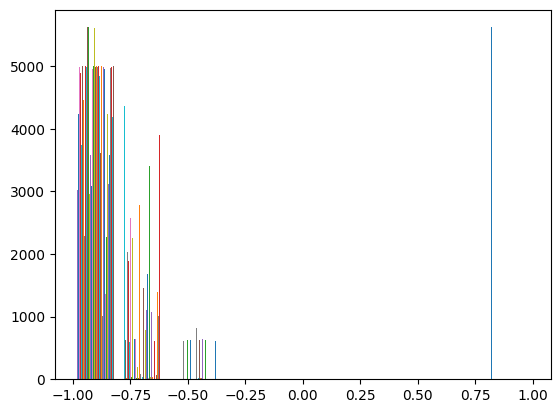

In [28]:
plt.hist(out.cpu().detach().numpy())